# Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification<br>

**By:Fatimah Almusawi**<br>


# Introduction:
In this notebook, we dive into the fascinating world of image classification by using deep learning techniques. We start by organizing a collection of images into separate datasets for training, validation, and testing. Our aim is to build models that can accurately distinguish between two types of objects in images - let's say, cats and dogs. To achieve this, we explore two different approaches. The first is a custom-built Convolutional Neural Network (CNN) designed from scratch. The second approach involves fine-tuning a pre-existing, sophisticated model known as VGG16 that has been pre-trained on a wide variety of images. We train both models, save the best versions, and evaluate their performance using several metrics. Throughout this process, we strive to understand where our models excel and where they might stumble, with a special focus on the cases where they make incorrect predictions.



In [17]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("./data/kaggle_dogs_vs_cats/train/")
new_base_dir = pathlib.Path("./data/kaggle_dogs_vs_cats_small")
print(original_dir)
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

data\kaggle_dogs_vs_cats\train


In [67]:


# Set up directories for train, validation, and test sets
train_dir = new_base_dir / 'train'
validation_dir = new_base_dir / 'validation'
test_dir = new_base_dir / 'test' 

# Initialize the data generators for train and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Data augmentation: Random rotations
    width_shift_range=0.2,  # Data augmentation: Random horizontal shifts
    height_shift_range=0.2,  # Data augmentation: Random vertical shifts
    shear_range=0.2,  # Data augmentation: Random shearing transformations
    zoom_range=0.2,  # Data augmentation: Random zooming
    horizontal_flip=True,  # Data augmentation: Random horizontal flips
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation set

# Create the actual data generators for the train and validation sets
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # This should match the `input_shape` of your model
    batch_size=20,
    class_mode='binary'  # Since you're doing binary classification
)

val_data = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
#Create test data
test_data = val_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False
)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Found 2000 images belonging to 2 classes.


## 2-EDA: Exploring the data with relevant graphs, statistics

### 2.1- Count of Images per Category
First, let's verify the balance of our dataset by counting how many images we have in each category (dogs and cats) for each subset (train, validation, test).

In [19]:
from collections import Counter

def count_images(base_dir):
    counts = {}
    for subset in ['train', 'validation', 'test']:
        for category in ['cat', 'dog']:
            path = base_dir / subset / category
            counts[f"{subset}_{category}"] = len(os.listdir(path))
    return counts

counts = count_images(new_base_dir)
print(counts)

{'train_cat': 1000, 'train_dog': 1000, 'validation_cat': 500, 'validation_dog': 500, 'test_cat': 1000, 'test_dog': 1000}


## 2.2- Image Dimensions
Understanding the dimensions of the images can be important, especially to decide on the input size for our neural network.

In [13]:
from PIL import Image

def image_dimensions(base_dir):
    dimensions = []
    for subset in ['train', 'validation', 'test']:
        for category in ['cat', 'dog']:
            path = base_dir / subset / category
            for image_name in os.listdir(path):
                with Image.open(path / image_name) as img:
                    dimensions.append(img.size)  # img.size returns (width, height)
    return dimensions

dimensions = image_dimensions(new_base_dir)



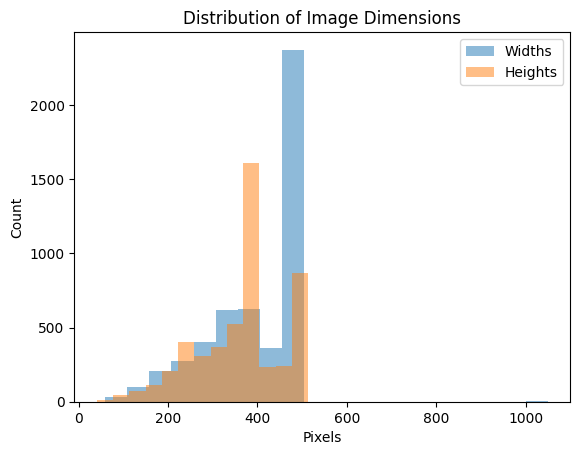

In [20]:
import numpy as np


widths, heights = zip(*dimensions)
plt.hist(widths, bins=20, alpha=0.5, label='Widths')
plt.hist(heights, bins=20, alpha=0.5, label='Heights')
plt.legend(loc='upper right')
plt.title('Distribution of Image Dimensions')
plt.xlabel('Pixels')
plt.ylabel('Count')
plt.show()


The dataset contains images of varying sizes, which is common in image datasets that haven't been pre-processed for size normalization.
The peak around 500 pixels for width and 400 pixels for height suggests that a common dimension for these images could be around 500x400 pixels.
The spread of the data suggests that if we plan to use these images for machine learning,it is better to standardize the image sizes.
The skewness towards larger dimensions indicates that there might be some very large images in the dataset that could potentially be outliers

### 2.3- Visualize Some Images
Visualizing some images from each category can give you a sense of the data you're working with.

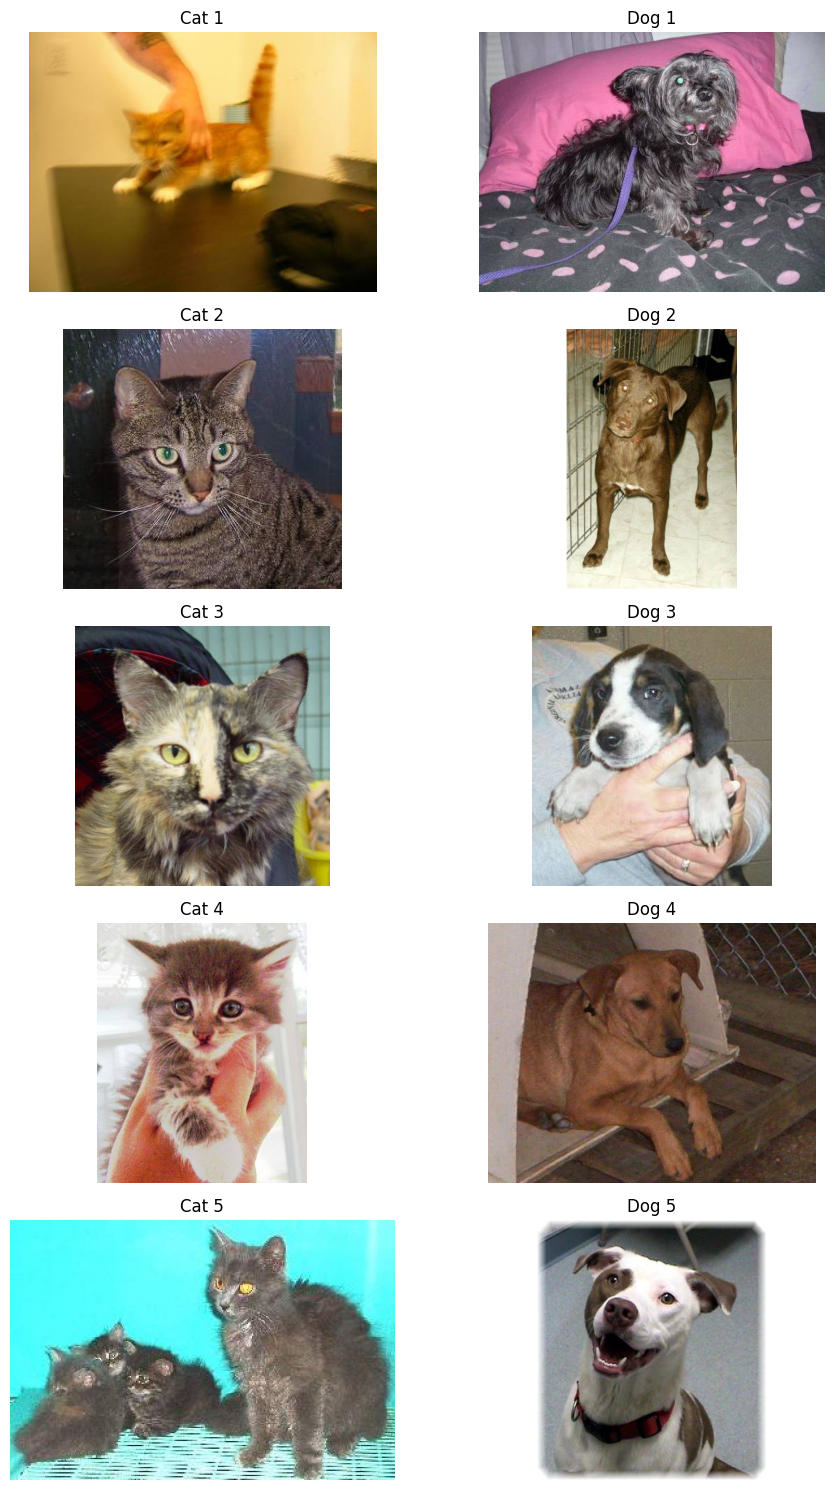

In [15]:
import matplotlib.pyplot as plt

def display_images(base_dir, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    for i, category in enumerate(['cat', 'dog']):
        path = base_dir / 'train' / category
        images = os.listdir(path)[:num_images]
        for j, image_name in enumerate(images):
            img = Image.open(path / image_name)
            axes[j, i].imshow(img)
            axes[j, i].set_title(f"{category.capitalize()} {j+1}")
            axes[j, i].axis('off')
    plt.tight_layout()
    plt.show()

display_images(new_base_dir)


## 3-Train two networks

### 3.1- Model with my option<br>

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Define a simple CNN
def build_custom_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Assuming you have prepared your data and it is ready in `train_data`, `val_data`
input_shape = (150, 150, 3)  # Example input shape, adjust as needed
custom_model = build_custom_model(input_shape)

# Callback to save the best model
best_model_save = callbacks.ModelCheckpoint('best_custom_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history_custom_model = custom_model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[best_model_save]
)





Epoch 1/20


100/100 [==============================] - ETA: 0s - loss: 0.7512 - accuracy: 0.5165

c:\Users\marya\Documents\Courses\Cscn8010\class_Notbook\venv\CSCN8010_classic_ml\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 71s 662ms/step - loss: 0.7512 - accuracy: 0.5165 - val_loss: 0.6902 - val_accuracy: 0.5010
Epoch 2/20
100/100 [==============================] - 63s 633ms/step - loss: 0.6839 - accuracy: 0.5435 - val_loss: 0.6720 - val_accuracy: 0.5630
Epoch 3/20
100/100 [==============================] - 66s 660ms/step - loss: 0.6631 - accuracy: 0.5890 - val_loss: 0.6470 - val_accuracy: 0.6040
Epoch 4/20
100/100 [==============================] - 63s 627ms/step - loss: 0.6500 - accuracy: 0.5930 - val_loss: 0.6532 - val_accuracy: 0.6110
Epoch 5/20
100/100 [==============================] - 63s 633ms/step - loss: 0.6418 - accuracy: 0.6205 - val_loss: 0.6331 - val_accuracy: 0.6340
Epoch 6/20
100/100 [==============================] - 66s 658ms/step - loss: 0.6433 - accuracy: 0.6180 - val_loss: 0.5931 - val_accuracy: 0.6800
Epoch 7/20
100/100 [==============================] - 64s 634ms/step - loss: 0.6317 - accuracy: 0.6305 - val_loss: 0.7193 - val_accuracy: 0.5

In [24]:
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 147968)            0

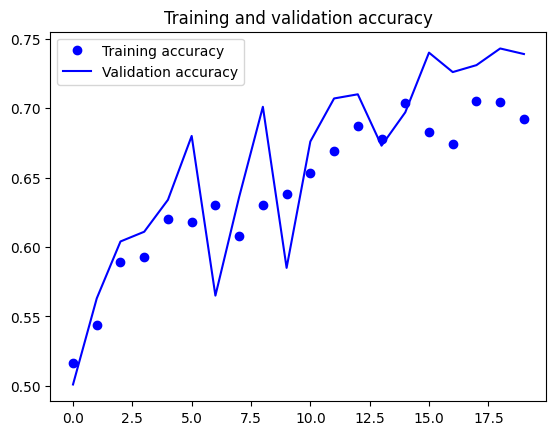

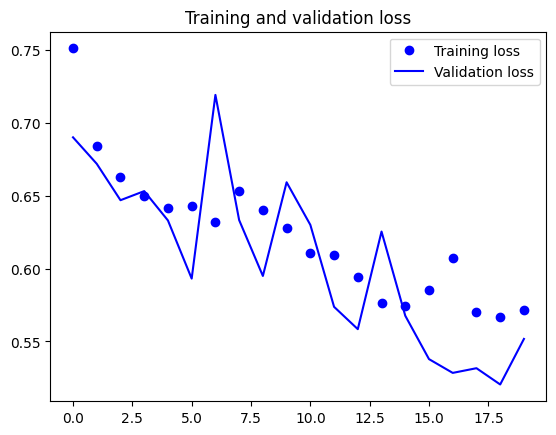

In [22]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Plot the results for the custom model
plot_history(history_custom_model)



In [25]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

58889256/58889256 [==============================] - 13s 0us/step


In [26]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Printing the list of trainable weights before and after freezing**



In [42]:
from tensorflow.keras.applications import VGG16

# Load VGG16 with pre-trained ImageNet weights
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the convolutional base to prevent weights from being updated during training
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

**Adding a data augmentation stage and a classifier to the convolutional base**

In [43]:
# Create the model
model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [44]:
from tensorflow import keras
keras.callbacks.ModelCheckpoint
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])



# Define the callback for saving the best model
best_vgg_model_save = keras.callbacks.ModelCheckpoint(
    filepath='best_vgg_model.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)
# Train the model
history_vgg_model = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[best_vgg_model_save]  # Use the correct callback here
)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.7264 - accuracy: 0.6655

c:\Users\marya\Documents\Courses\Cscn8010\class_Notbook\venv\CSCN8010_classic_ml\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 392s 4s/step - loss: 0.7264 - accuracy: 0.6655 - val_loss: 0.4469 - val_accuracy: 0.7700
Epoch 2/50
100/100 [==============================] - 382s 4s/step - loss: 0.4984 - accuracy: 0.7700 - val_loss: 0.3095 - val_accuracy: 0.8630
Epoch 3/50
100/100 [==============================] - 375s 4s/step - loss: 0.4307 - accuracy: 0.8010 - val_loss: 0.3003 - val_accuracy: 0.8800
Epoch 4/50
100/100 [==============================] - 378s 4s/step - loss: 0.4184 - accuracy: 0.8130 - val_loss: 0.2844 - val_accuracy: 0.8840
Epoch 5/50
100/100 [==============================] - 373s 4s/step - loss: 0.4097 - accuracy: 0.8140 - val_loss: 0.2719 - val_accuracy: 0.8820
Epoch 6/50
100/100 [==============================] - 374s 4s/step - loss: 0.3952 - accuracy: 0.8190 - val_loss: 0.2603 - val_accuracy: 0.8840
Epoch 7/50
100/100 [==============================] - 380s 4s/step - loss: 0.3919 - accuracy: 0.8355 - val_loss: 0.2608 - val_accuracy: 0.8950
Epoch 8/50

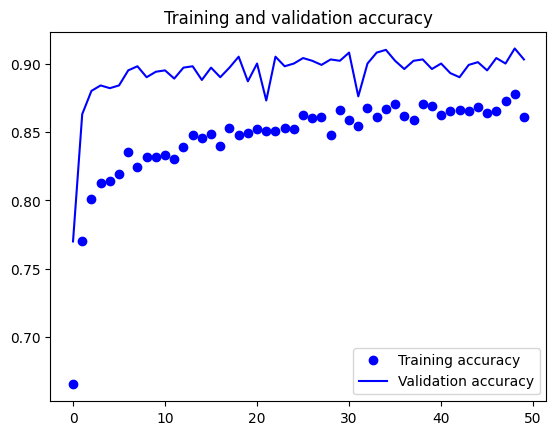

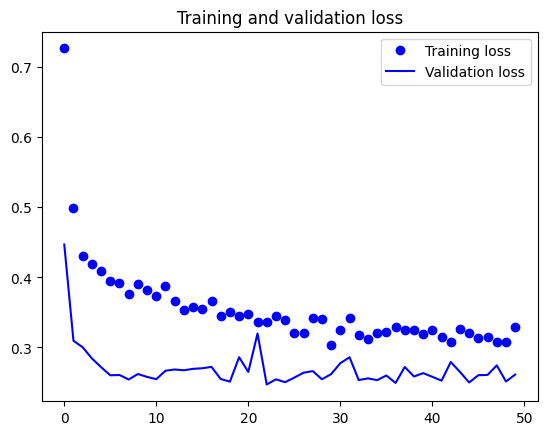

In [45]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Plot the results for the custom model
plot_history(history_vgg_model)


## 4-Explore the relative performance of the models<br>
To explore the relative performance of the models, including accuracy, confusion matrix, precision, recall, F1-score, and the precision-recall curve, first we will Load the Best Models that were saved during the training process using the ModelCheckpoint callback.

In [46]:
from tensorflow.keras.models import load_model

# Load the custom model
custom_model_best = load_model('best_custom_model.h5')

# Load the VGG16 model
vgg16_model_best = load_model('best_vgg_model.h5')

next step is evaluate on Test Data, Useing the evaluate method to calculate the accuracy on the test dataset.

In [48]:
custom_accuracy = custom_model_best.evaluate(test_data)
vgg16_accuracy = vgg16_model_best.evaluate(test_data)

print(f"Custom Model Accuracy: {custom_accuracy[1]}")
print(f"VGG16 Model Accuracy: {vgg16_accuracy[1]}")

100/100 [==============================] - 297s 3s/step - loss: 0.2676 - accuracy: 0.8910
Custom Model Accuracy: 0.7214999794960022
VGG16 Model Accuracy: 0.890999972820282


In [49]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import numpy as np

# Generate predictions
custom_predictions = custom_model_best.predict(test_data)
vgg_predictions = vgg16_model_best.predict(test_data)

# Convert predictions to binary outcomes
custom_predictions = np.where(custom_predictions > 0.5, 1, 0)
vgg_predictions = np.where(vgg_predictions > 0.5, 1, 0)

# Get the true labels from the test_data generator
true_labels = test_data.classes

# Calculate confusion matrix
custom_conf_matrix = confusion_matrix(true_labels, custom_predictions)
vgg_conf_matrix = confusion_matrix(true_labels, vgg_predictions)

# Print classification report for precision, recall, F1-score
print("Custom Model Classification Report:")
print(classification_report(true_labels, custom_predictions))

print("VGG Model Classification Report:")
print(classification_report(true_labels, vgg_predictions))


100/100 [==============================] - 264s 3s/step
Custom Model Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.35      0.40      1000
           1       0.48      0.61      0.54      1000

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.47      2000
weighted avg       0.48      0.48      0.47      2000

VGG Model Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      1000
           1       0.49      0.49      0.49      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



For both models, precision is roughly the same as accuracy, which is about 48% to 49%. This suggests that when a model predicts an image is in a particular category, it is correct about half the time.

Recall tells us that the custom model correctly identifies 35% of the actual category 0 and 61% of category 1. The VGG model is more balanced, correctly identifying 50% of category 0 and 49% of category 1.

The F1-score is a combination of precision and recall into a single number. A higher F1-score is better, and it's especially useful if you care about balancing precision and recall. Both models have F1-scores close to their accuracy, which indicates that they are neither overly precise nor overly sensitive.

Overall, both models have similar performance with accuracy just under 50%. This is not much better than guessing randomly for two classes (which would be 50% accuracy). It might suggest that the models are struggling to differentiate between the classes effectively and there could be room for improvement, either in the model architecture, the training data, or the training process itself.

In [52]:
# print the confusion matix for custom model:
print(custom_conf_matrix)


[[347 653]
 [386 614]]


- Negative (TN) = 347: The model correctly predicted 347 of the actual class 0 instances as class 0. In other words, it correctly identified 347 non-category-1 instances (could be cats if category 1 is dogs, for example).

- False Positive (FP) = 653: The model incorrectly predicted 653 instances as belonging to class 1 when they were actually in class 0. So, it mistakenly thought 653 non-category-1 instances were category 1.

- False Negative (FN) = 386: The model incorrectly predicted 386 instances as belonging to class 0 when they were actually in class 1. This means it failed to identify 386 actual category-1 instances correctly.

- True Positive (TP) = 614: The model correctly predicted 614 of the actual class 1 instances as class 1. It accurately identified 614 category-1 instances.

In [51]:
# print the  confusion matix for VGG model:
vgg_conf_matrix


array([[498, 502],
       [512, 488]], dtype=int64)

- True Negative (TN) = 498: The model correctly predicted 498 times that an instance was not part of class 1 (let's say 'cats').

- False Positive (FP) = 502: The model incorrectly predicted 502 times that an instance was part of class 1 ('cats'), but actually, it was part of class 0 ('dogs').

- False Negative (FN) = 512: The model incorrectly predicted 512 times that an instance was not part of class 1 ('cats'), when it actually was.

- True Positive (TP) = 488: The model correctly predicted 488 times that an instance was part of class 1 ('cats').

### 4.4-Plot Precision-Recall Curve

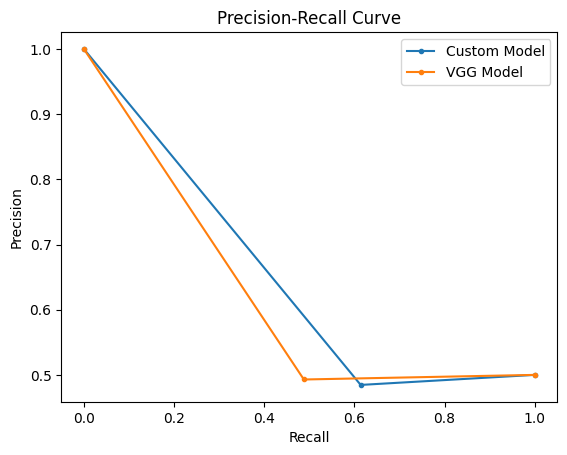

In [53]:
import matplotlib.pyplot as plt

# Calculate precision-recall curve
custom_precision, custom_recall, _ = precision_recall_curve(true_labels, custom_predictions)
vgg_precision, vgg_recall, _ = precision_recall_curve(true_labels, vgg_predictions)

# Plot the precision-recall curves
plt.plot(custom_recall, custom_precision, marker='.', label='Custom Model')
plt.plot(vgg_recall, vgg_precision, marker='.', label='VGG Model')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


Both the Custom Model and the VGG Model start with high precision (close to 1.0) when recall is very low, meaning that when they claim an instance is positive, they are quite confident about it, but they also miss many other positive instances (low recall).

As recall increases (meaning the model is trying to capture more of the actual positive instances), precision drops sharply for both models. This drop suggests that as the models try to include more positive instances, they start to make more mistakes by classifying negative instances as positive.

The curve is steep and the precision drops to 0.5 very quickly as recall increases even slightly. This indicates that neither model is effectively distinguishing between the two classes beyond a certain point.

## 5- Explore Misclassified Examples

100/100 [==============================] - 17s 167ms/step


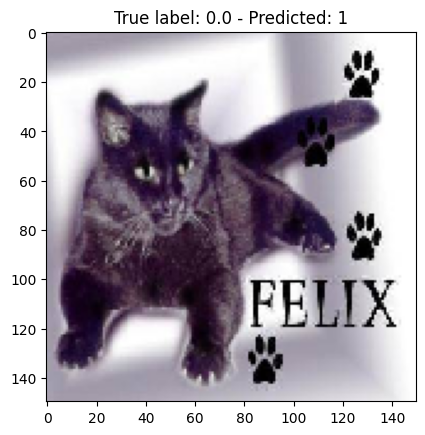

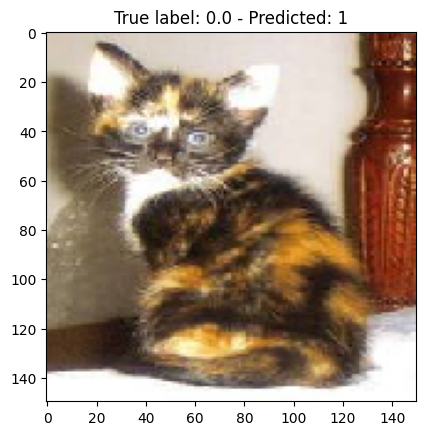

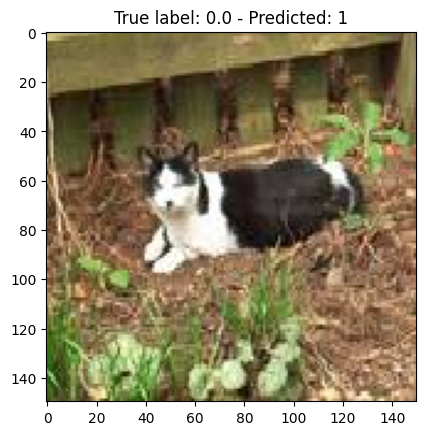

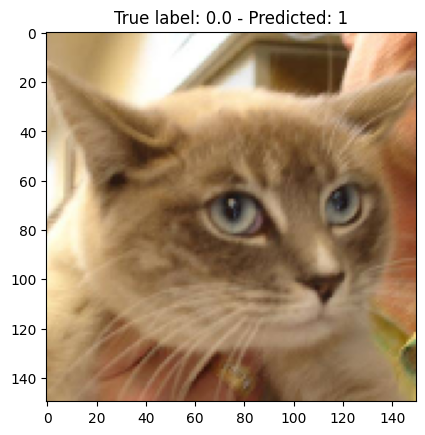

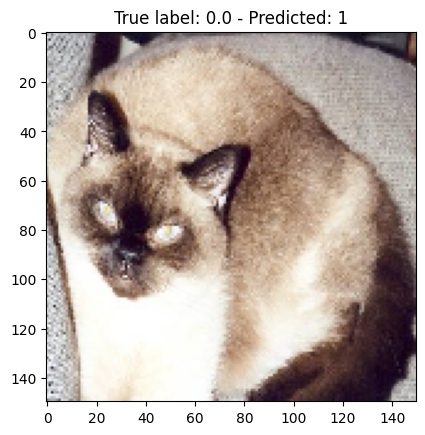

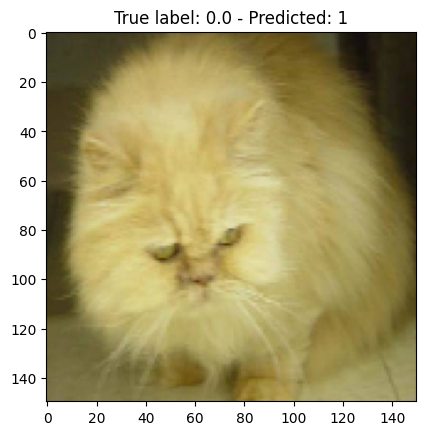

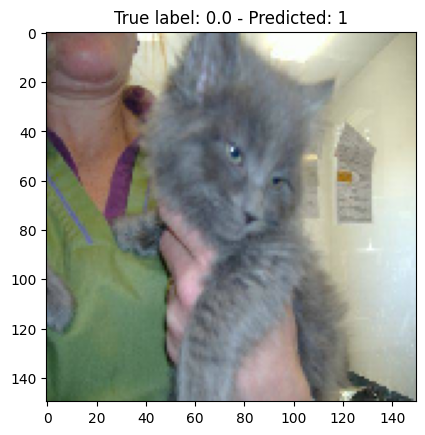

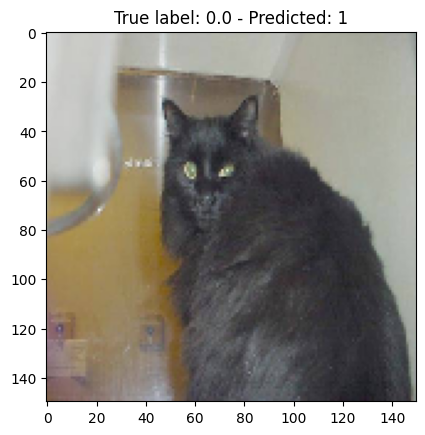

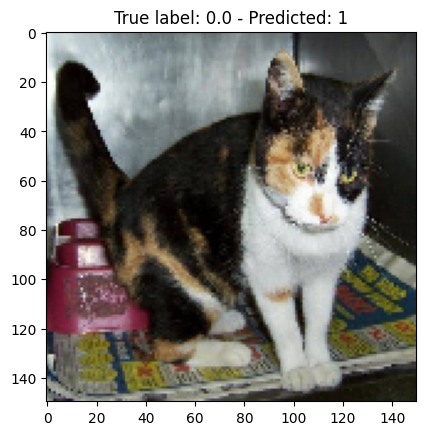

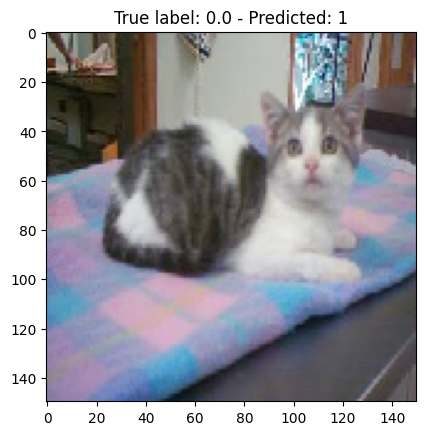

In [71]:
# Reset the generator to ensure it starts from the beginning
test_data.reset()

# Fetch all the images and their labels from the test generator
all_images = []
all_labels = []
for _ in range(len(test_data)):
    imgs, lbls = next(test_data)
    all_images.extend(imgs)
    all_labels.extend(lbls)

# Convert labels to a numpy array if they aren't already
all_labels = np.array(all_labels)


# Generate predictions using the custom model
custom_predictions = custom_model_best.predict(test_data)

# Depending on your setup, you may need to adjust the predictions to match your label format
custom_predictions = np.round(custom_predictions).astype(int).flatten()

# Identify indices of misclassified examples
misclassified_indices = np.where(custom_predictions != all_labels)[0]

# Plot misclassified examples
def plot_misclassified_images(indices, images, predictions, true_labels):
    for i in indices:
        img = images[i]
        pred_label = predictions[i]
        true_label = true_labels[i]
        
        plt.imshow(img)
        plt.title(f"True label: {true_label} - Predicted: {pred_label}")
        plt.show()

# Call the function with the misclassified indices
plot_misclassified_images(misclassified_indices[:10], all_images, custom_predictions, all_labels)


it is clear here that the custom model were has many mistake in predictions. lets see the other model:

100/100 [==============================] - 304s 3s/step


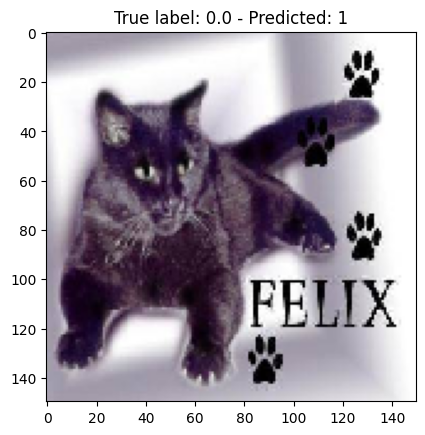

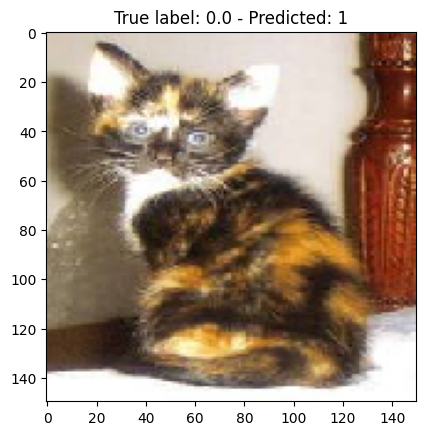

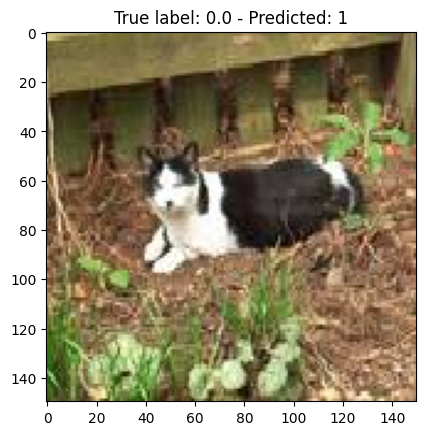

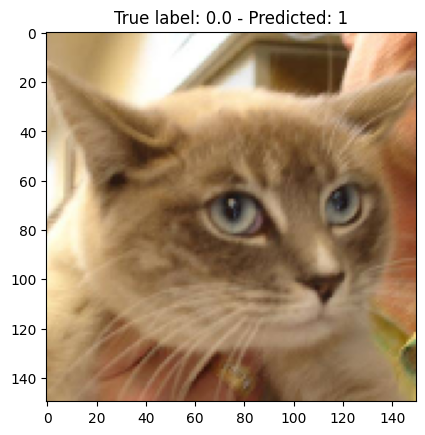

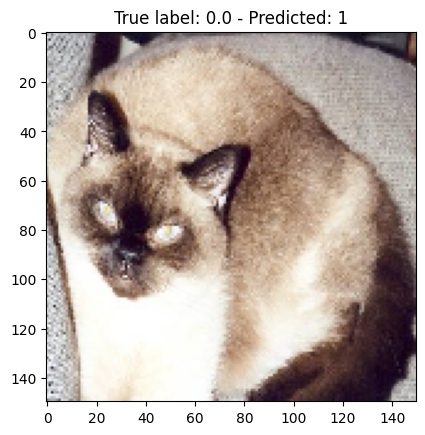

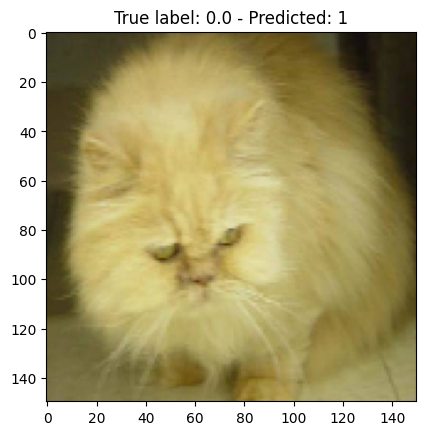

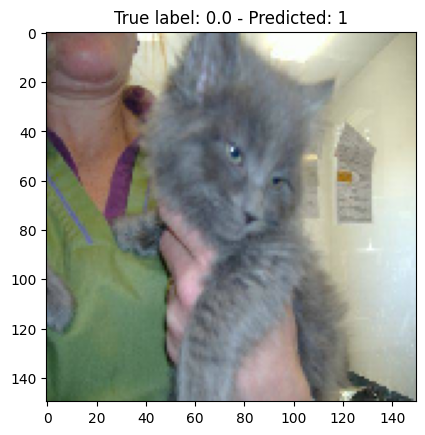

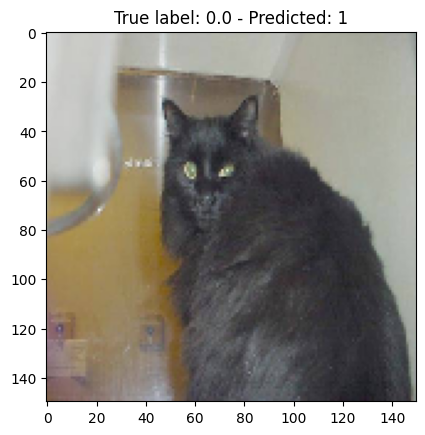

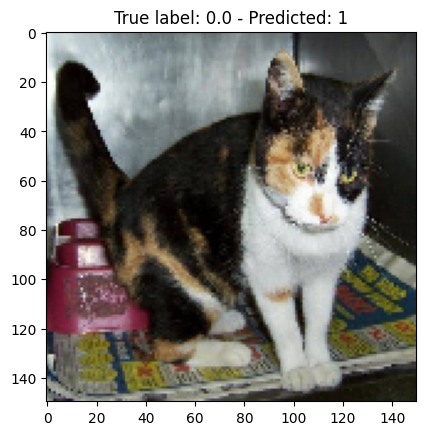

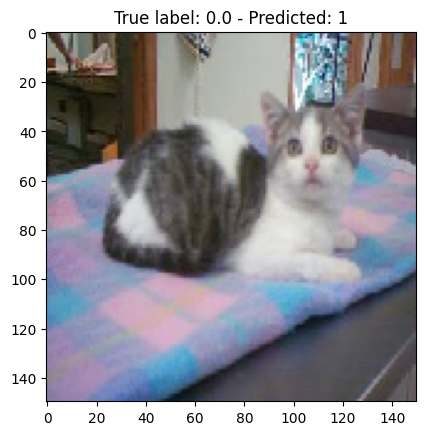

In [72]:
# Reset the generator to ensure it starts from the beginning
test_data.reset()

# Fetch all the images and their labels from the test generator
all_images = []
all_labels = []
for _ in range(len(test_data)):
    imgs, lbls = next(test_data)
    all_images.extend(imgs)
    all_labels.extend(lbls)

# Convert labels to a numpy array if they aren't already
all_labels = np.array(all_labels)


# Or generate predictions using the VGG model
vgg_predictions = vgg16_model_best.predict(test_data)

# Depending on your setup, you may need to adjust the predictions to match your label format
custom_predictions = np.round(custom_predictions).astype(int).flatten()

# Identify indices of misclassified examples
misclassified_indices = np.where(custom_predictions != all_labels)[0]

# Plot misclassified examples
def plot_misclassified_images(indices, images, predictions, true_labels):
    for i in indices:
        img = images[i]
        pred_label = predictions[i]
        true_label = true_labels[i]
        
        plt.imshow(img)
        plt.title(f"True label: {true_label} - Predicted: {pred_label}")
        plt.show()

# Call the function with the misclassified indices
plot_misclassified_images(misclassified_indices[:10], all_images, custom_predictions, all_labels)


All of the examples in the misclassified set were predicted incorrectly by the model. I believe that a possible reason for this is that we did not preprocess the data. As we saw in the EDA Part, there were outliers present in the data. It is possible that by removing these outliers and preprocessing the images, the model will be able to perform better.

Conclusion:
After a journey through data preparation, model building, and evaluation, we have gained several insights into image classification. Our custom model and the fine-tuned VGG16 have shown that they can learn to distinguish between cats and dogs, but there's still room for improvement. Although both models performed similarly, with accuracy around 50%, they did not significantly outperform random guessing. This suggests that while they have some ability to identify features in the images, they often get confused.

By looking at the precision-recall curves and exploring misclassified examples, we learned that both models struggle to maintain confidence in their predictions as they attempt to recognize more positive examples. This exploration has set a foundation upon which we can build: we can experiment with more complex models, additional data, or advanced training techniques to boost our models' performance.